## Ornish

The dataset comes from the publication of the MEvA-X tool for biomarker discovery. It contains microarry gene expression, with information of Age, Gender, COPD, Diabetes, and WeightLoss, making 13524 features on 89 samples. The WeightLoss information was transformed into a binary variable: Responders for those with a weight loss higher than 10%, and Non_responders otherwise. The objective is to investigate the relationship between weight loss and gene expression profiles. See more information at *MEvA-X: a hybrid multiobjective evolutionary tool using an XGBoost classifier for biomarkers discovery on biomedical datasets* (https://doi.org/10.1093/bioinformatics/btad384 and https://github.com/PanKonstantinos/MEvA-X).

In [105]:
import pandas as pd
import xgboost as xgb
import os
import multiprocessing
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import seaborn as sns
#import urllib.request

In [106]:
inputFile = '../data/Ornish.csv'
df = pd.read_csv(inputFile, index_col=0)
df.dropna(axis=0, inplace=True)
print(df.shape)
print(df.head())

(89, 13520)
                A1CF       A2M    A4GALT     A4GNT      AAAS      AACS  \
GSM1123226  1.997137  2.927813  3.379954  3.118075  4.511405  4.087969   
GSM1123229  1.977951  2.815217  3.554587  3.421110  3.975408  3.698030   
GSM1123232  2.000448  2.699377  3.859986  3.109845  4.412049  3.750196   
GSM1123235  2.163751  2.597491  3.735692  3.248038  4.336756  3.884665   
GSM1123238  2.264534  2.766004  3.839986  3.389460  4.405672  3.635781   

               AADAC     AAGAB      AAK1     AAMDC  ...      ZXDB      ZXDC  \
GSM1123226  2.214993  4.288835  3.572398  3.250973  ...  2.020370  5.075711   
GSM1123229  2.135038  4.303349  3.600630  3.562200  ...  2.151221  4.695243   
GSM1123232  1.999807  4.254621  3.444927  3.533278  ...  2.090296  4.818034   
GSM1123235  2.133586  3.978215  3.238115  3.383351  ...  2.000901  4.682398   
GSM1123238  2.041702  4.077370  3.724022  3.518026  ...  2.227170  4.376936   

                 ZYX     ZZEF1      ZZZ3       Age  Sex  COPD  Diabe

In this dataset, weight loss information transformed into a binary label: participants with a weight loss higher than a selected threshold equal to 10% were considered to belong in the positive class (Responders), whereas participants with lower weight loss or even increased weight were considered to belong in the negative class (Non_responders).

Let's keep the `WeightLoss` apart as reponse and convert to numeric (0,1) values.

In [ ]:
X = df.drop(columns=['WeightLoss'])
Y = df['WeightLoss']
mapping = {'Non_responders': 0, 'Responders':1}
inv_mapping = {v: k for k, v in mapping.items()}
Y = Y.map(mapping)
print(X.shape)
print(Y.value_counts())

(89, 13519)
WeightLoss
1    54
0    35
Name: count, dtype: int64


Investigate distribution of gene expression

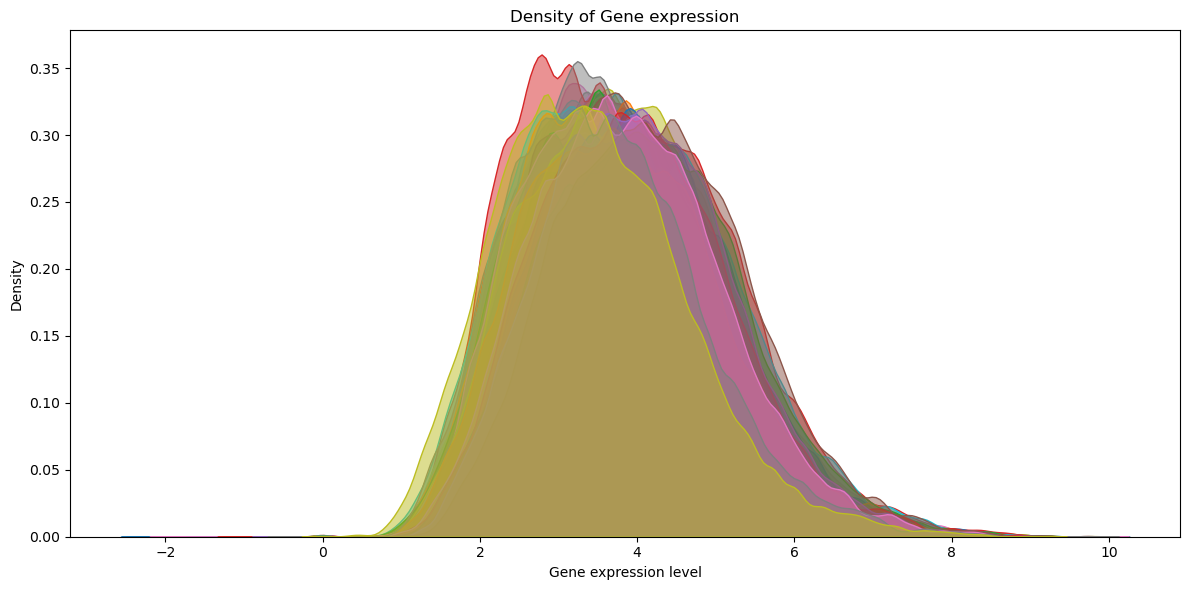

In [108]:
plt.figure(figsize=(12, 6))

# plot density for each sample
for i in range(X.shape[0]):
    sns.kdeplot(X.iloc[i,:], bw_adjust=0.5, fill=True, alpha=0.5)

plt.title('Density of Gene expression')
plt.xlabel('Gene expression level')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

Perform PCA on gene expression data and visualize with the response or certain features on different components.

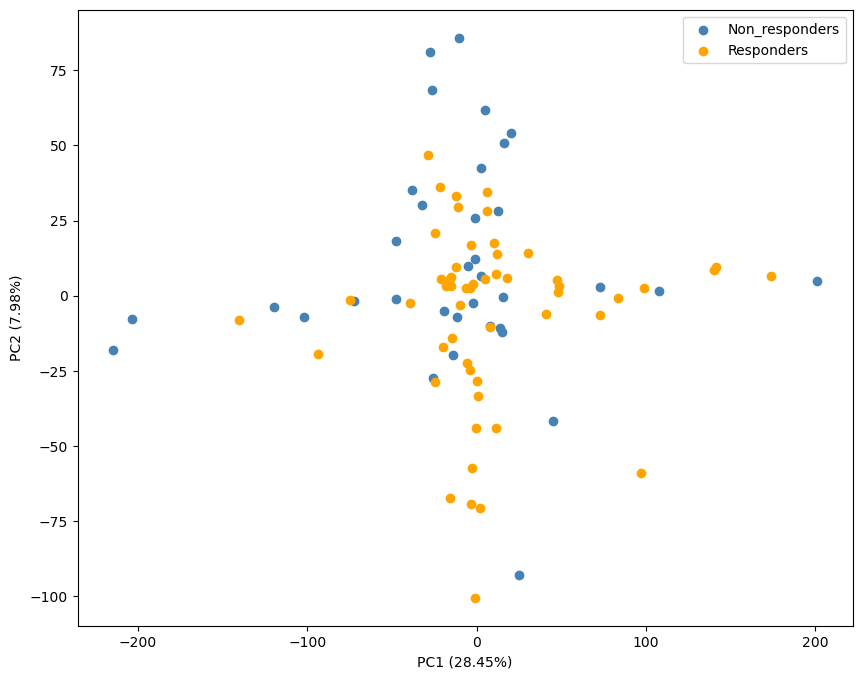

In [110]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

# standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# scatter plot of the first two principal components
plt.figure(figsize=(10, 8))

labels = Y
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], color='steelblue', label=inv_mapping[0])
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], color='orange', label=inv_mapping[1])
plt.legend()

plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))

plt.show()

The goal of this project is to find gene biomarker for the weight loss response. There are 13514 genes in the data, thus applying XGBoost and SHAP directly can be tricky due to the curse of dimensionality. Certain approaches could be considered, for instance, i) use unsupervised feature selection with principal components, ii) supervised filtering to keep top genes most correlated with the response (`SelectKBest`), iii) modules of coregulated genes.